# Solving the **Burger's equation**:
# $ u_t + uu_x - \nu u_{xx} = 0 $
* # $ x \in [-1, 1] $
* # $ t \in [0, 1] $

# 1. Initial condtion:
# $u(x, 0) = - sin(\pi x)$

# 2. Boundary conditions:
* # $u(-1, t) = 0$
* # $u(1, t) = 0$

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from datetime import datetime
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
from torch.utils.data import Dataset, DataLoader
from scipy.stats import qmc
from scipy.io import loadmat

# Helpers

## Plots

In [2]:
def plot3D(x,t,y):
  # x_plot =x.squeeze(1)
  # t_plot =t.squeeze(1)
  # X,T= torch.meshgrid(x_plot,t_plot)
  F_xt = y
  fig,ax=plt.subplots(1,1)
  # cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  cp = ax.contourf(t,x, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(t, x, F_xt,cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

## PINN

In [3]:
class FeedForward(nn.Module):
  def __init__(self,
               layers,
               activation=nn.ReLU(),
               weight_init=None,
               bias_init=None):

    super().__init__()
    self.n_layers = len(layers) - 1
    self.layers = layers
    self.activation = activation
    self.weight_init = weight_init
    self.bias_init = bias_init

    dense_layers = [
        self.dense_layer(in_features=self.layers[i],
                         out_features=self.layers[i+1])
        for i in range(self.n_layers - 1)]
    dense_layers.append(nn.Linear(in_features=self.layers[-2],
                                  out_features=self.layers[-1]))

    self.feed_forward = nn.Sequential(*dense_layers)

  def dense_layer(self, in_features, out_features):
    dense_layer = nn.Sequential(
      nn.Linear(in_features=in_features,
                out_features=out_features),
    )

    if self.weight_init is not None:
        self.weight_init(dense_layer[0].weight)

    if self.bias_init is not None:
        self.bias_init(dense_layer[0].bias)

    dense_layer.add_module("activation", self.activation)
    return dense_layer

  def forward(self, x):
    return self.feed_forward(x)

In [4]:
class PINN():
  def __init__(self,
               XT_c_scaled,
               XT_bi_scaled,
               u_bi, v,
               XT_test_scaled,
               layers,
               epochs,
               patience,
               chkpt_path='model.pth',
               activation=nn.ReLU(),
               dtype=torch.float32,
               device='cpu'):

    super().__init__()

    # Some constants
    self.device = device
    self.dtype = dtype
    self.v = torch.tensor(v, dtype=dtype, device=device)
    self.u_bi = torch.tensor(u_bi, dtype=dtype, device=device)
    self.XT_c_scaled = torch.tensor(XT_c_scaled, dtype=dtype, device=device)
    self.XT_bi_scaled = torch.tensor(XT_bi_scaled, dtype=dtype, device=device)
    self.XT_test_scaled = torch.tensor(XT_test_scaled, dtype=dtype, device=device)
    self.epochs = epochs
    self.chkpt_path = chkpt_path
    self.patience = patience

    # Neural network
    self.feed_forward = FeedForward(layers=layers,
                                    activation=activation,
                                    weight_init=lambda m: nn.init.xavier_normal_(m.data, nn.init.calculate_gain('tanh')),
                                    bias_init=lambda m: nn.init.zeros_(m.data))

    # Setting optimizer
    self.optimizer = torch.optim.LBFGS(self.feed_forward.parameters(),
                                       lr=1,
                                       max_iter=250,  # max_iter=2000,
                                       max_eval=None,
                                       tolerance_grad=1e-07,
                                       tolerance_change=1e-09,
                                       history_size=100,
                                       line_search_fn='strong_wolfe')  # None or 'strong_wolfe'

  def calculate_u(self, xt):
    return self.feed_forward(xt)

  def calculate_f(self, XT):
    x = XT[:, 0].clone().detach().requires_grad_(True)
    t = XT[:, 1].clone().detach().requires_grad_(True)

    u = self.calculate_u(torch.cat((x.view(-1, 1), t.view(-1, 1)), dim=1))

    u_t = torch.autograd.grad(
        u, t,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    u_x = torch.autograd.grad(
        u, x,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    u_xx = torch.autograd.grad(
        u_x, x,
        grad_outputs=torch.ones_like(u_x),
        retain_graph=True,
        create_graph=True
    )[0]

    f_hat = u_t + u.squeeze()*u_x.squeeze() - self.v*u_xx

    return f_hat

  def loss_bi(self):
    u_bi_hat = self.calculate_u(self.XT_bi_scaled)
    loss_bi = torch.mean((self.u_bi - u_bi_hat) ** 2)
    return loss_bi

  def loss_c(self):
    f_hat = self.calculate_f(self.XT_c_scaled)
    return torch.mean(f_hat ** 2)

  def train_loss(self):
    train_loss = self.loss_bi() + self.loss_c()
    return train_loss

  def test_loss(self):
    f_hat = self.calculate_f(self.XT_test_scaled)
    return torch.mean(f_hat ** 2)

  def closure(self):
    train_loss = self.train_loss()
    self.optimizer.zero_grad()
    train_loss.backward()
    return train_loss.detach().item()

  def train(self, print_per_epochs):
    t0 = pd.Timestamp.now()
    self.feed_forward.train()
    train_losses = list()
    test_losses = list()
    for epoch in tqdm(range(self.epochs)):
      flag = 0
      train_loss_bi = self.loss_bi().detach().item()
      train_loss_c = self.loss_c().detach().item()
      train_loss = self.optimizer.step(self.closure)
      test_loss = self.test_loss().detach().item()
      train_losses.append(train_loss)
      test_losses.append(test_loss)
      if epoch == 0:
        best_val_loss = test_loss
        best_epoch = -1
        self.checkpoint()
        flag = 1
        print(f"Epoch: {epoch+1}/{self.epochs} | Loss_BIC: {train_loss_bi} | Loss_C: {train_loss_c} | Loss: {train_loss} | Test loss: {test_loss} - *Checkpoint*")
      else:
        if test_loss < best_val_loss:
          best_val_loss = test_loss
          best_epoch = epoch
          self.checkpoint()
          flag = 1
          if epoch % print_per_epochs == 0:
            print(f"Epoch: {epoch+1}/{self.epochs} | Loss_BIC: {train_loss_bi} | Loss_C: {train_loss_c} | Loss: {train_loss} | Test loss: {test_loss} - *Checkpoint*")
        elif epoch - best_epoch > self.patience:
          if epoch % print_per_epochs == 0:
            print(f"\nEarly stopping applied at epoch {epoch}.")
          break
      if (flag == 0) and (epoch % print_per_epochs == 0):
        print(f"Epoch: {epoch+1}/{self.epochs} | Loss_BIC: {train_loss_bi} | Loss_C: {train_loss_c} | Loss: {train_loss} | Test loss: {test_loss}")

    print(f"\nTOTAL TRAINING TIME: ")
    self.timer(t0, pd.Timestamp.now())

    return train_losses, test_losses

  def format_output(x):
    n2 = abs(int(np.log10(x)))
    n1 = x / (10 ** n2)
    formatted_x = f"{n1:.2f} * e^-{n2}"
    return formatted_x

  def checkpoint(self):
    torch.save({
      "optimizer": self.optimizer.state_dict(),
      "model": self.feed_forward.state_dict()
    }, self.chkpt_path)

  def timer(self, start, end):
    dt = pd.Timedelta(end - start)
    seconds = dt.seconds
    minutes = seconds / 60.
    hours = seconds / 3600.
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))

# DATA GENERATION

In [5]:
# ============================= TRAINING DATA =============================
x_min, x_max = -1, 1
t_min, t_max = 0, 1

# **************  Create and Scale collocation points ******************

# --- 1st choice: Random Grid ---
Nc = 20_000
XT_c = qmc.scale(qmc.LatinHypercube(2).random(Nc), [x_min, t_min], [x_max, t_max])

N_x0 = 1_000
x0 = np.linspace(0., 0., N_x0).reshape(-1, 1)
t_x0 = np.linspace(t_min, t_max, N_x0).reshape(-1, 1)
X_x0 = np.concatenate((x0, t_x0), axis=1)

XT_c = np.concatenate((XT_c, X_x0), axis=0)

# # --- 2nd choice: Uniform Grid ---
# Nx_c, Nt_c = 500, 300
# xc = np.linspace(x_min, x_max, Nx_c)
# tc = np.linspace(t_min, t_max, Nt_c)
# X_mesh, T_mesh = np.meshgrid(xc, tc)
# XT_c = np.concatenate((X_mesh.flatten().reshape(-1, 1), T_mesh.flatten().reshape(-1, 1)), axis=1)

# N_x0 = 1_000
# x0 = np.linspace(0., 0., N_x0).reshape(-1, 1)
# t_x0 = np.linspace(t_min, t_max, N_x0).reshape(-1, 1)
# X_x0 = np.concatenate((x0, t_x0), axis=1)

# XT_c = np.concatenate((XT_c, X_x0), axis=0)

scaler_c = MinMaxScaler()
XT_c_scaled = scaler_c.fit_transform(XT_c)

# ************** Initial condition (t=0: u(x)=-sin(pi*x)) **************
# ************** Boundary Conditions (x=-1 or 1: u(t)=0) ***************
Nbi = 1_000

XT_0 = np.concatenate((np.linspace(x_min, x_max, Nbi).reshape(-1, 1), np.zeros(Nbi).reshape(-1, 1)), axis=1)
XT_l = np.concatenate((-np.ones(Nbi).reshape(-1, 1), np.linspace(t_min, t_max, Nbi).reshape(-1, 1)), axis=1)
XT_r = np.concatenate((np.ones(Nbi).reshape(-1, 1), np.linspace(t_min, t_max, Nbi).reshape(-1, 1)), axis=1)

u0 = - np.sin(np.pi * np.linspace(x_min, x_max, Nbi)).reshape(-1, 1)
ub = np.zeros((Nbi, 1))

XT_bi = np.concatenate((XT_0, XT_l, XT_r), axis=0)
scaler_bi = MinMaxScaler()
XT_bi_scaled = scaler_c.fit_transform(XT_bi)

u_bi = np.concatenate((u0, ub, ub), axis=0)
# **********************************************************************

print(XT_c_scaled.shape)
print(XT_bi_scaled.shape, u_bi.shape)


# ============================= VALIDATION DATA =============================
# Get correct solution (probably solved in MATLAB throught some other classical technique)
!wget https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat

test_data = loadmat('burgers_shock.mat')
t, x = np.meshgrid(test_data['t'], test_data['x'])

XT_test = np.concatenate((x.reshape(-1, 1), t.reshape(-1, 1)), axis=1)
XT_test_scaled = torch.tensor(scaler_c.transform(XT_test), dtype=torch.float32)
u_test = test_data['usol'].reshape(-1, 1)

(21000, 2)
(3000, 2) (3000, 1)
--2023-09-11 08:18:34--  https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maziarraissi/PINNs/master/appendix/Data/burgers_shock.mat [following]
--2023-09-11 08:18:34--  https://raw.githubusercontent.com/maziarraissi/PINNs/master/appendix/Data/burgers_shock.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 207944 (203K) [application/octet-stream]
Saving to: ‘burgers_shock.mat’

burgers_shock.mat   100%[===================>] 203.07K  --.-KB/s    in 0.03s   

2023-09-11 08:18:35 (6.93 MB

In [8]:
x

array([[-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [-0.99215686, -0.99215686, -0.99215686, ..., -0.99215686,
        -0.99215686, -0.99215686],
       [-0.98431373, -0.98431373, -0.98431373, ..., -0.98431373,
        -0.98431373, -0.98431373],
       ...,
       [ 0.98431373,  0.98431373,  0.98431373, ...,  0.98431373,
         0.98431373,  0.98431373],
       [ 0.99215686,  0.99215686,  0.99215686, ...,  0.99215686,
         0.99215686,  0.99215686],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ]])

In [9]:
t

array([[0.  , 0.01, 0.02, ..., 0.97, 0.98, 0.99],
       [0.  , 0.01, 0.02, ..., 0.97, 0.98, 0.99],
       [0.  , 0.01, 0.02, ..., 0.97, 0.98, 0.99],
       ...,
       [0.  , 0.01, 0.02, ..., 0.97, 0.98, 0.99],
       [0.  , 0.01, 0.02, ..., 0.97, 0.98, 0.99],
       [0.  , 0.01, 0.02, ..., 0.97, 0.98, 0.99]])

# TRAIN

In [187]:
EPOCHS = int(20)
PATIENCE = 100
LAYERS = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]    # [2, 50, 50, 50, 1]
PATH = "model.pth"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

pinn = PINN(
    XT_c_scaled=XT_c,
    XT_bi_scaled=XT_bi,
    u_bi=u_bi,
    XT_test_scaled=XT_test,
    v=0.01/np.pi,
    layers=LAYERS,
    epochs=EPOCHS,
    patience=EPOCHS+1,
    activation=nn.Tanh()
)

train_loss, test_loss = pinn.train(print_per_epochs=1)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1/20 | Loss_BIC: 0.22508087754249573 | Loss_C: 0.25393837690353394 | Loss: 0.47901925444602966 | Test loss: 0.003099340246990323 - *Checkpoint*
Epoch: 2/20 | Loss_BIC: 0.002660755068063736 | Loss_C: 0.0030140667222440243 | Loss: 0.00567482179030776 | Test loss: 0.0006614777958020568 - *Checkpoint*
Epoch: 3/20 | Loss_BIC: 0.00037112037534825504 | Loss_C: 0.0006340710096992552 | Loss: 0.0010051913559436798 | Test loss: 0.00038082231185398996 - *Checkpoint*
Epoch: 4/20 | Loss_BIC: 0.00011715368600562215 | Loss_C: 0.00033683725632727146 | Loss: 0.0004539909423328936 | Test loss: 0.00022334963432513177 - *Checkpoint*
Epoch: 5/20 | Loss_BIC: 5.435691127786413e-05 | Loss_C: 0.0001987506984733045 | Loss: 0.000253107602475211 | Test loss: 0.00018769702001009136 - *Checkpoint*
Epoch: 6/20 | Loss_BIC: 4.261257709003985e-05 | Loss_C: 0.00015547989460173994 | Loss: 0.0001980924716917798 | Test loss: 0.00016003966447897255 - *Checkpoint*
Epoch: 7/20 | Loss_BIC: 3.3973621611949056e-05 | Loss_C

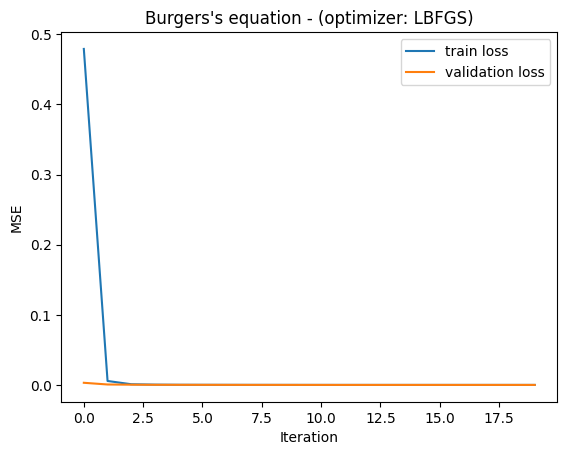

In [188]:
plt.figure()
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='validation loss')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.legend()
plt.title("Burgers's equation - (optimizer: LBFGS)")
plt.show()

# INFERENCE

In [189]:
checkpoint = torch.load("model.pth")
pinn.feed_forward.load_state_dict(checkpoint['model'])

with torch.inference_mode():
  u_pred = pinn.feed_forward.forward(torch.tensor(XT_test, dtype=torch.float32)).detach().cpu().numpy()

test_error = u_test - u_pred
test_nmse = np.linalg.norm(u_test - u_pred, 2) / np.linalg.norm(u_test, 2)
print(f'Test error: {test_nmse}')

Test error: 0.005436050150389746


In [190]:
df = pd.DataFrame(
    {
        't': t.flatten(),
        'x': x.flatten(),
        'u_real': u_test.flatten(),
        'u': u_pred.flatten()
    }
)
df['abs_error'] = abs(df['u_real'] - df['u'])
df.to_csv('burgers_pinn.csv', index=False)

In [191]:
df.sort_values(by='abs_error', ascending=False).head()

,t,x,u_real,u,abs_error
12850,0.50,0.003922,-0.532003,-0.478354,0.053649
12849,0.49,0.003922,-0.530429,-0.477007,0.053422
12851,0.51,0.003922,-0.532468,-0.479328,0.053140
12848,0.48,0.003922,-0.527555,-0.475183,0.052372
12852,0.52,0.003922,-0.531985,-0.479977,0.052008


# PLOTS

In [192]:
u_pred = u_pred.reshape(x.shape)
u_test = u_test.reshape(x.shape)

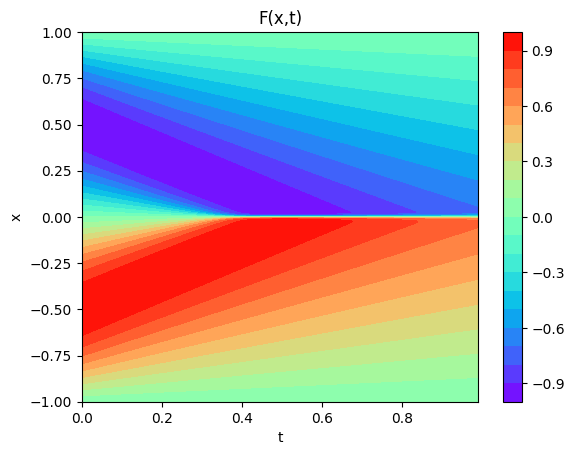

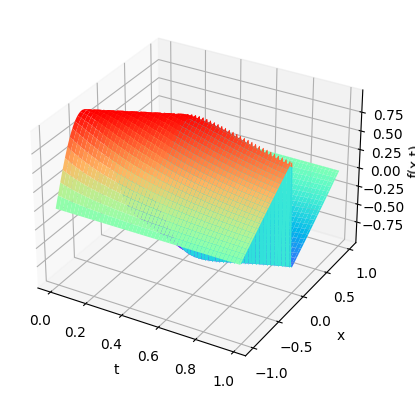

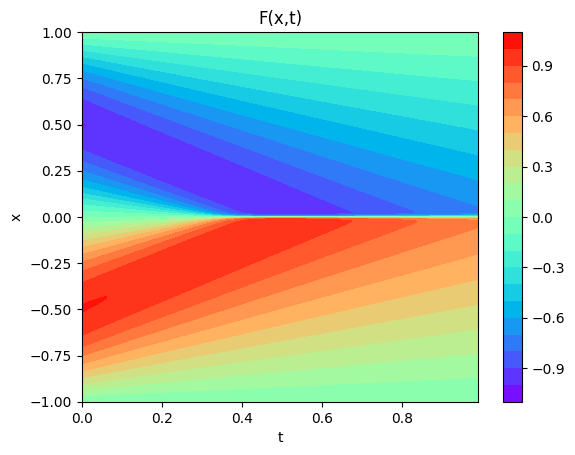

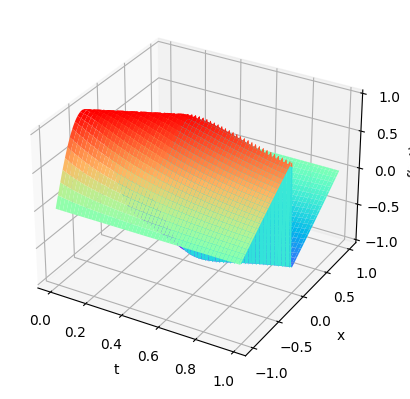

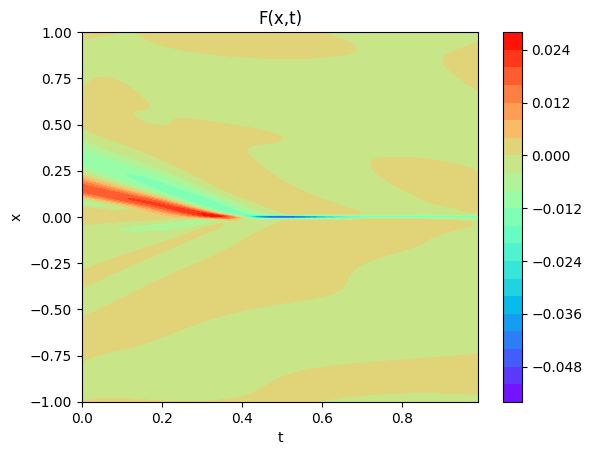

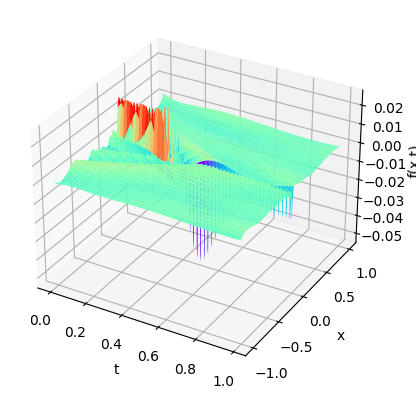

In [193]:
plot3D(x, t, u_test)
plot3D(x, t, u_pred)
plot3D(x, t, test_error.reshape(x.shape))

# Check first derivatives...

In [180]:
checkpoint = torch.load("model.pth")
pinn.feed_forward.load_state_dict(checkpoint['model'])

XT_test = torch.tensor(XT_test, dtype=torch.float32)

x_test = XT_test[:, 0].flatten()
x_test.requires_grad = True

t_test = XT_test[:, 1].flatten()
t_test.requires_grad = True

u_pred = pinn.feed_forward.forward(torch.cat((x_test.view(-1, 1), t_test.view(-1, 1)), dim=1)).flatten()

u_pred_x = torch.autograd.grad(u_pred, x_test, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
u_pred_t = torch.autograd.grad(u_pred, t_test, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]

print(u_pred_x.shape, u_pred_t.shape)

torch.Size([25600]) torch.Size([25600])


In [181]:
u_x = u_pred_x.detach().numpy()
u_t = u_pred_t.detach().numpy()
x = x_test.detach().numpy()
t = t_test.detach().numpy()

grad_u_df = pd.DataFrame(
  {
      'x': x,
      't': t,
    'u_x': u_x,
    'u_t': u_t,
    'grad_abs_2': np.sqrt(u_x ** 2 + u_t ** 2)
  }
)

df_sorted = grad_u_df.sort_values(by='grad_abs_2', ascending=False)

In [182]:
df_sorted

,x,t,u_x,u_t,grad_abs_2
12850,0.003922,0.50,-111.299797,-0.171597,111.299927
12849,0.003922,0.49,-111.272278,-0.281699,111.272629
12851,0.003922,0.51,-111.138168,-0.077383,111.138191
12848,0.003922,0.48,-111.013046,-0.411508,111.013809
12852,0.003922,0.52,-110.822388,0.004053,110.822388
...,...,...,...,...,...
7105,-0.443137,0.05,-0.018055,-0.011788,0.021562
12045,-0.058824,0.45,-0.008407,-0.019367,0.021113
8617,-0.325490,0.17,-0.012308,-0.015599,0.019870
7609,-0.403922,0.09,-0.013223,-0.013612,0.018978


<Axes: xlabel='x', ylabel='t'>

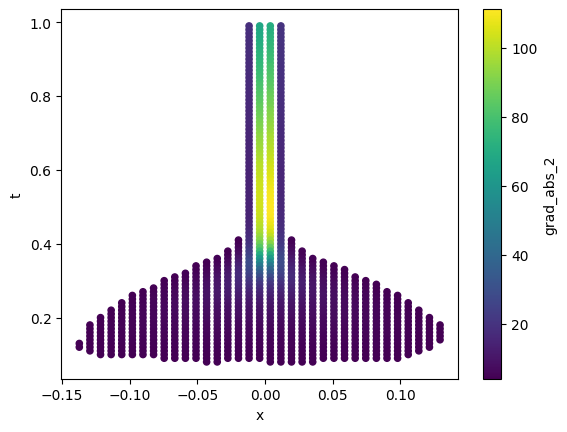

In [185]:
top_N = 1000
top_df = df_sorted.head(top_N)

top_df.plot.scatter(x='x', y='t', c='grad_abs_2')